# Full vehicle model

In [2]:
import numpy as np
import pandas as pd
import math
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

## Drive cycle import

In [3]:
df_drivecycle = pd.read_excel(r'drive_cycles\drive_cycle_itr4.xlsx', sheet_name = 'itr4_avg')

In [4]:
df_drivecycle.columns

Index(['time_s', 'speed_kmph', 'accn_mps2', 'avg_speed_kmph', 'avg_accn_mps2'], dtype='object')

## Parameters

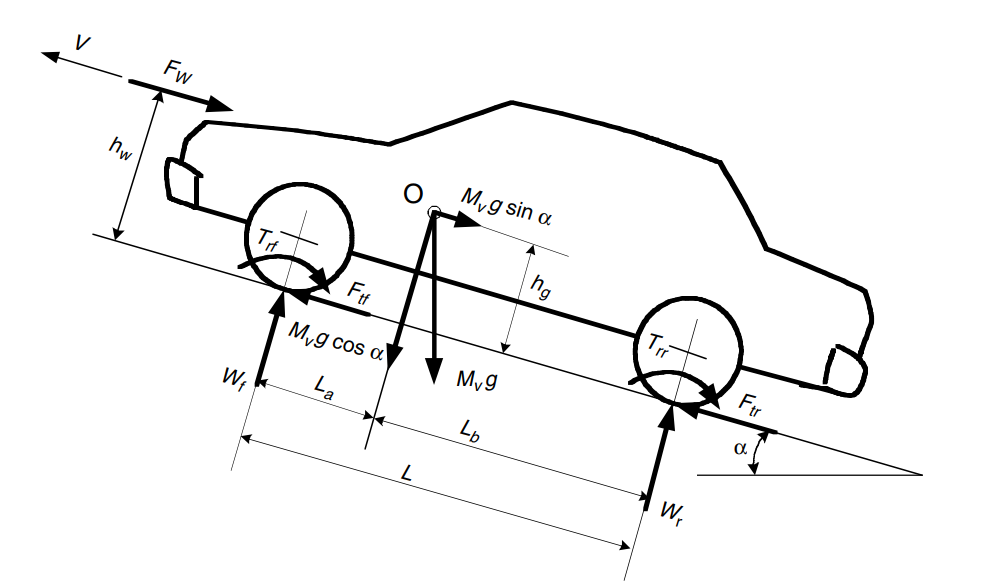

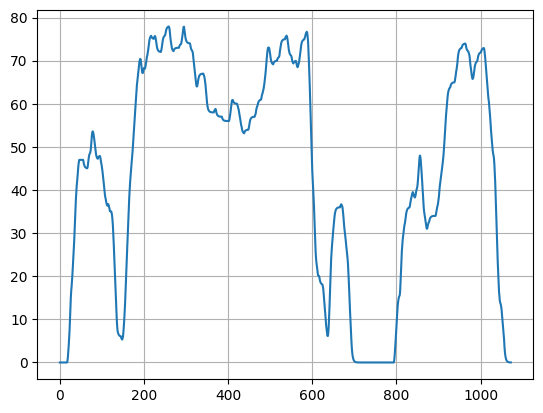

In [5]:
plt.plot(df_drivecycle['time_s'], df_drivecycle['avg_speed_kmph'])
plt.grid()

### vehicle parameters (select - 0)

In [6]:
vehicle_param = {'mass': 300, #kg
                 'g' : 9.81, #m/s^2 
                 'c_rr': 0.017,
                 'c_d': 0.9,
                 'f_area': 0.42, #m^2
                 'rho': 1.2, #kg/m^3
                 'gradient': 0, #deg
                 'v_air': 0, #tail wind in vehicle direction kmph
                 'wb' : 1.340, #m
                 'x_cg': .713, #m
                 'z_cg': .633, #m
                 'w_r' : 0.3, #m (average radius of front and rear wheel)
                 'i_whl' : 0.42, #kgm2 rolling inertia of wheel
                 'Eff_chain': 0.99,
                 'R_whl_gb': 3.294, # reduction ratio between gearbox and wheel
                 'i_gb' : 0.002, #kgm2
                 'Eff_gb' : 0.99,
                 'R_gb_mtr' : 1.676, # reduction ratio between gearbox and motor
                 'i_mtr' : 0.004 #kgm2
                 }


### coastdown parameters (select - 1)

In [7]:
coastdown_param = {'A' :48.78, #N
                   'B' :0, #N/kmph
                   'C' :0.025 #N/kmph^2
                   }

## Vehicle Force model

### Force Model

In [8]:
veh0_coast1 = 0

In [9]:
if veh0_coast1 == 0:
    # Fr = (0.01*(1+df_drivecycle['avg_speed_kmph'].to_numpy()/(3.6*100)))*vehicle_param['mass']*vehicle_param['g']*math.cos(math.radians(vehicle_param['gradient'])) #for speed under 128kmph
    Fr = vehicle_param['c_rr']*vehicle_param['mass']*vehicle_param['g']*math.cos(math.radians(vehicle_param['gradient']))
    Far = (0.5*vehicle_param['rho']*vehicle_param['f_area']*vehicle_param['c_d']/3.6**2)*(df_drivecycle['avg_speed_kmph'].to_numpy()+vehicle_param['v_air'])**2
    Fgr = vehicle_param['c_rr']*vehicle_param['mass']*vehicle_param['g']*math.sin(math.radians(vehicle_param['gradient']))
    Fac = vehicle_param['mass']*df_drivecycle['avg_accn_mps2'].to_numpy()
    Fr = Fr+Far+Fgr+Fac
    print('F_calc')
else:
    Fr = coastdown_param['A']
    Far = coastdown_param['C']*df_drivecycle['avg_speed_kmph']**2
    Fac = vehicle_param['mass']*df_drivecycle['avg_accn_mps2']
    Fr = Fr + Far + Fac
    print('F_coast')

F_calc


In [10]:
max(Fr)

314.4585726592741

### Roational resistance model

#### wheel

In [11]:
Tr = Fr*vehicle_param['w_r'] #Nm

In [12]:
Td_whl = Tr
# drive_Td_whl = np.clip(Tr, a_min = 0, a_max = None)
alpha_whl = df_drivecycle['avg_accn_mps2'].to_numpy()/vehicle_param['w_r']
torque_whl = alpha_whl * vehicle_param['i_whl']
itorque_whl = Td_whl + torque_whl
rpm_whl = ((df_drivecycle['avg_speed_kmph'].to_numpy()/3.6)/(2*math.pi*vehicle_param['w_r']))*60

#### gearbox

In [13]:
T_gb = itorque_whl/(vehicle_param['R_whl_gb']*vehicle_param['Eff_chain'])
alpha_gb = alpha_whl * vehicle_param['R_whl_gb']
torque_gb = alpha_gb * vehicle_param['i_gb']
itorque_gb = T_gb + torque_gb
rpm_gb = rpm_whl * vehicle_param['R_whl_gb']

#### motor

In [14]:
T_mtr = itorque_gb/(vehicle_param['R_gb_mtr']*vehicle_param['Eff_gb'])
alpha_mtr = alpha_gb * vehicle_param['R_gb_mtr']
torque_mtr = alpha_mtr * vehicle_param['i_mtr']
itorque_mtr = T_mtr + torque_mtr
rpm_mtr = rpm_gb * vehicle_param['R_gb_mtr']

#### drive forces

In [15]:
drive_itorque_whl = np.clip(itorque_whl, a_min = 0, a_max = None)
drive_itorque_gb= np.clip(itorque_gb, a_min = 0, a_max = None)
drive_itorque_mtr = np.clip(itorque_mtr, a_min = 0, a_max = None)

#### braking forces

In [16]:
brake_itorque_whl = np.clip(itorque_whl, a_min = None, a_max = 0)
# brake_itorque_whl = brake_itorque_whl[brake_itorque_whl != 0] 

brake_itorque_gb= np.clip(itorque_gb, a_min = None, a_max = 0)
# brake_itorque_gb = brake_itorque_gb[brake_itorque_gb != 0] 

brake_itorque_mtr = np.clip(itorque_mtr, a_min = None, a_max = 0)
# brake_itorque_mtr = brake_itorque_mtr[brake_itorque_mtr != 0] 

## Motor and Controller

In [17]:
mtr_eff_map = pd.read_csv(r"mtr_eff.csv", index_col = [0])
mtr_eff_arr = mtr_eff_map.values

In [18]:
mtr_eff_dc = []
for actual_torque, actual_rpm in zip(drive_itorque_mtr, rpm_mtr):
    mtr_eff_dc.append(mtr_eff_arr[int(actual_rpm//100),int(actual_torque/10)])

mtr_eff_dc = np.array(mtr_eff_dc)

In [19]:
mtr_ctrl_eff_map = pd.read_csv(r"mtr_ctrl_eff.csv", index_col = [0])
mtr_ctrl_eff_arr = mtr_ctrl_eff_map.values

In [20]:
mtr_ctrl_eff_dc = []
for actual_torque, actual_rpm in zip(drive_itorque_mtr, rpm_mtr):
    mtr_ctrl_eff_dc.append(mtr_ctrl_eff_arr[int(actual_rpm//100),int(actual_torque/10)])

mtr_ctrl_eff_dc = np.array(mtr_ctrl_eff_dc)

Text(0, 0.5, 'Efficiency %')

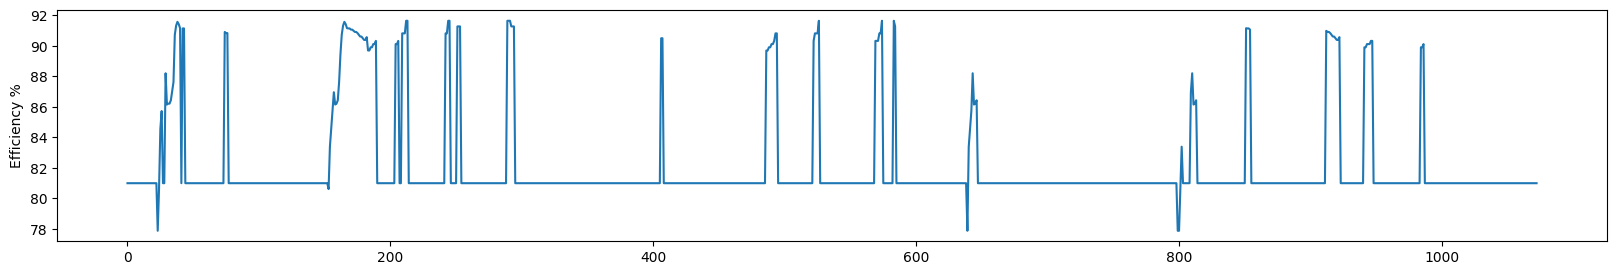

In [21]:
total_mtr_system_eff_dc = mtr_ctrl_eff_dc * mtr_eff_dc/10000
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(total_mtr_system_eff_dc*100)
plt.ylabel("Efficiency %")

In [62]:
import plotly.graph_objects as go

fig1 = go.Figure(data=[go.Surface(z=mtr_eff_arr)])
fig1.update_layout(title='Motor Efficiency', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig1.show()

In [61]:
fig2 = go.Figure(data=[go.Surface(z=mtr_ctrl_eff_arr)])

fig2.update_layout(title='Motor Controller Efficiency', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig2.show()

In [90]:
fig5 = go.Figure(data=[go.Surface(z=((mtr_ctrl_eff_arr*mtr_eff_arr).transpose()))])

fig5.update_layout(title='Total Motor Efficiency', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig5.show()

In [53]:
total_itorque_mtr = brake_itorque_mtr + drive_itorque_mtr
# plt.plot(total_itorque_mtr)
df_total_itorque_mtr  = pd.DataFrame()
df_total_itorque_mtr["drive_itorque_mtr"]= drive_itorque_mtr
df_total_itorque_mtr["total_itorque_mtr"] = total_itorque_mtr
df_total_itorque_mtr["rpm_mtr"] = rpm_mtr
df_total_itorque_mtr["total_mtr_system_eff_dc"] =   total_mtr_system_eff_dc
df_total_itorque_mtr["speed_kmph"] = df_drivecycle["speed_kmph"]
df_total_itorque_mtr["time_s"] = df_drivecycle["time_s"]

temp = df_total_itorque_mtr["total_mtr_system_eff_dc"]
df_total_itorque_mtr.loc[df_total_itorque_mtr["total_itorque_mtr"]<0,'total_mtr_system_eff_dc'] = np.nan


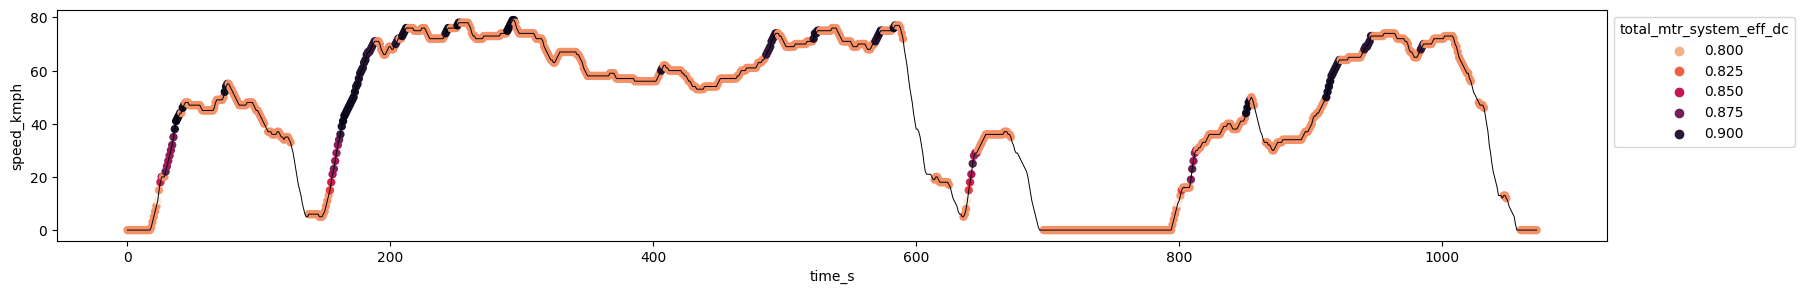

In [99]:
fig3 = sns.lineplot(data=df_total_itorque_mtr, x="time_s", y="speed_kmph",linewidth = 0.7, color = "black")
fig3 = sns.scatterplot(data=df_total_itorque_mtr, x="time_s", y="speed_kmph", hue="total_mtr_system_eff_dc",  palette = "rocket_r", linewidth = 0 )
sns.move_legend(fig3, "upper left", bbox_to_anchor=(1, 1))


In [86]:
total_mtr_eff_arr = mtr_eff_arr* mtr_ctrl_eff_arr/10000
total_mtr_eff_arr= (total_mtr_eff_arr.transpose())[::-1]


C:\Users\Dhanveerraj JM\AppData\Local\Temp\ipykernel_7848\867251208.py:16: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



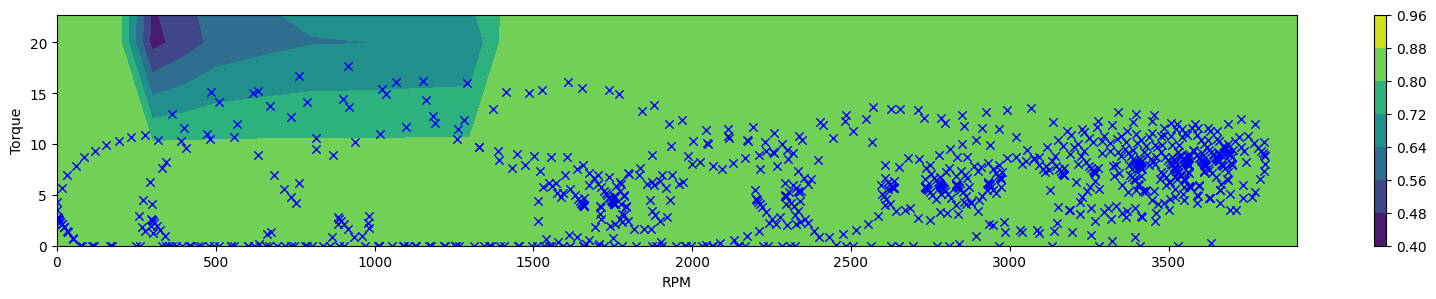

In [141]:
rpm = np.arange(0, 7100, 100)
torque = np.arange(0, 100, 10)

[X, Y] = np.meshgrid(rpm, torque)  
Z = total_mtr_eff_arr

fig, ax = plt.subplots(1, 1)
cs = ax.contourf(X, Y, Z)
cbar = fig.colorbar(cs)
ax = sns.scatterplot(data=df_total_itorque_mtr, x="rpm_mtr", y="drive_itorque_mtr", color = "blue", linewidth = 1, marker= "x")
ax.set_xlabel("RPM")
ax.set_ylabel("Torque")
# ax.legend().set_visible(False)
ax.set_xlim(0,max(df_total_itorque_mtr["rpm_mtr"])+100)
ax.set_ylim(0,max(df_total_itorque_mtr["drive_itorque_mtr"])+5)
fig.show()

## Regen